## 1. Of cats and cookies
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We're not kidding! Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" alt></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!</p>

In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
df.shape

(90189, 5)

## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [3]:
# Counting the number of players in each AB group.
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

## 3. The distribution of game rounds
<p><img src="https://assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>It looks like there is roughly the same number of players in each group, nice!</p>
<p>The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'User Count')

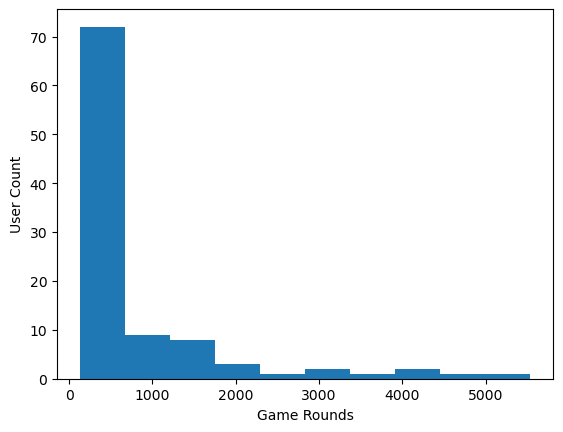

In [4]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of game rounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid", kind="hist")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## 4. Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>As a first step, let's look at what 1-day retention is overall.</p>

In [5]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

## 5. 1-day retention by AB-group
<p><img src="https://assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.</p>

In [6]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. Should we be confident in the difference?
<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?</p>
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

Text(0.5, 0, 'Mean 1 day retention')

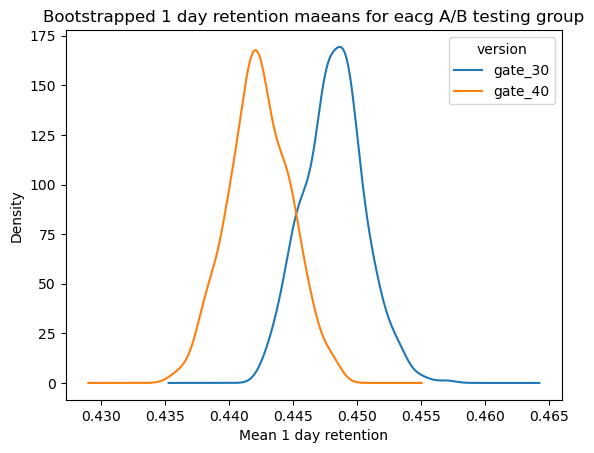

In [7]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
ax=boot_1d.plot.kde()
ax.set_title('Bootstrapped 1 day retention maeans for eacg A/B testing group')
ax.set_xlabel('Mean 1 day retention')

## 7. Zooming in on the difference
<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>
<p>(<em>Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.</em>)</p>

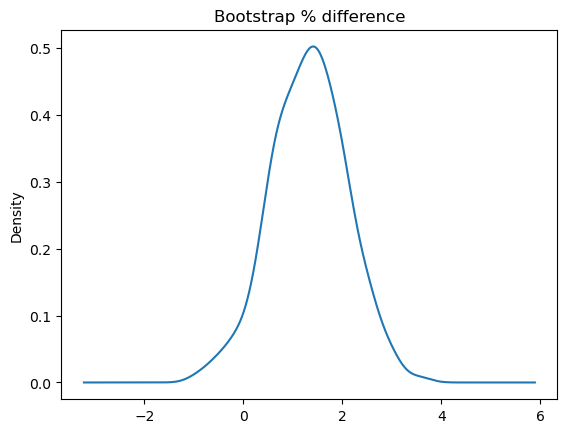

In [8]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d.gate_30-boot_1d.gate_40)/boot_1d.gate_40*100)

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_title('Bootstrap % difference')
ax.set_xlabel=('% difference in means between two A/B groups')

## 8. The probability of a difference
<p><img src="https://assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [9]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()

# Pretty printing the probability
'{0:.1%}'.format(prob)

'95.2%'

## 9. 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Let's start by calculating 7-day retention for the two AB-groups.</p>

In [10]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Text(0.5, 0, 'Mean 7 day retention')

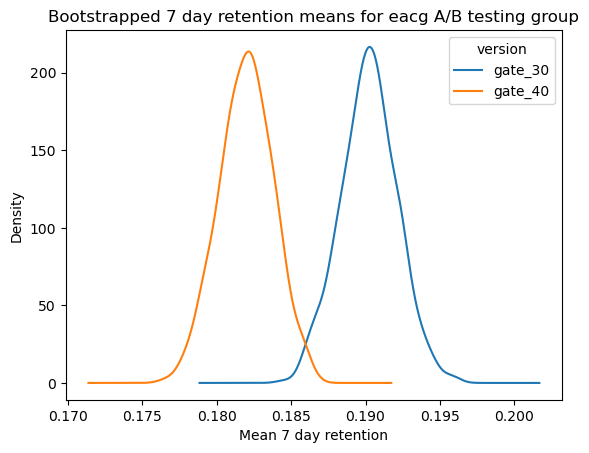

In [11]:
#this wasn't included in the datacamp project
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
ax=boot_1d.plot.kde()
ax.set_title('Bootstrapped 7 day retention means for eacg A/B testing group')
ax.set_xlabel('Mean 7 day retention')

## 10. Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'100.0%'

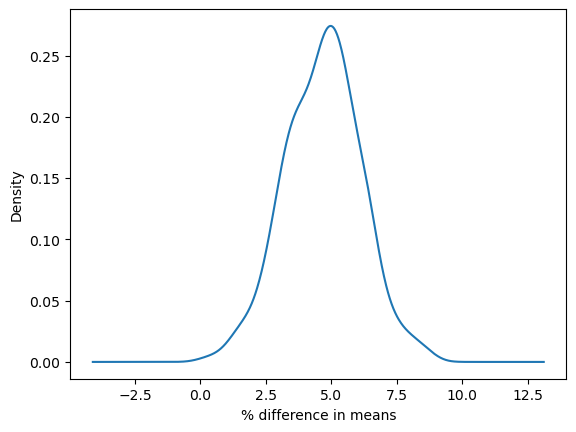

In [12]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = ((boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40']*100)

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff']>0).mean()

# Pretty printing the probability
'{0:.1%}'.format(prob)

## 11.  The conclusion
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>

In [13]:
# So, given the data and the bootstrap analysis
# Should we move the gate from level 30 to level 40 ?
move_to_level_40 = False # True or False ?

# Extension
## Research Question
What if the retention caused by the the number of game rounds played by the player during the first 14 days after install?

In [14]:
#data describe
df = pd.read_csv('datasets/cookie_cats.csv')
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [15]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [16]:
df.isnull().sum()
#no missing value

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [17]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

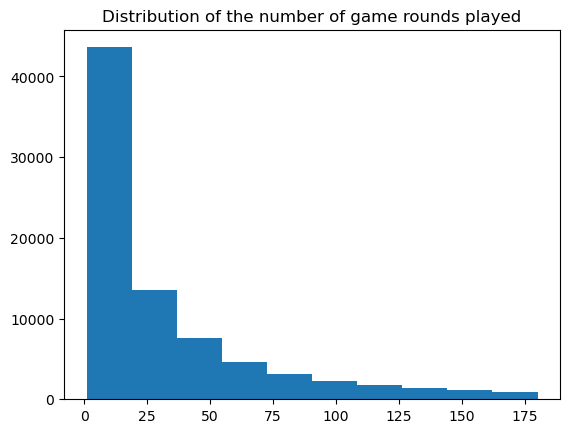

In [18]:
import matplotlib.pyplot as plt
plt.hist(x=df['sum_gamerounds'], range=[1, 180])
plt.title('Distribution of the number of game rounds played')
plt.show()

In [19]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

The variation in the numbe rof game rounds played is apparent from the above graph. On the one extreme, there are players who played the game almost 5.000 times, and on the other extreme there are players who haven't played the game after installation. 

Let's explore its impact on retention!

## Survival Analysis

Survival analysis focuses on the expected duration of time until an event of interest (continue playing-retention vs. not play) occurs. However, the event may not be observed for some individuals within the study time period (7 days after install), producing the so-called censored observations.

In this data, we have observations that a player has not (yet) stopped playing the game in the first 7 days after install. It emans that we have a right-censoring data. 

For the sake of survival analysis, I'll create two additional columns; 'time' and 'status'

* survival: 1 if 'retention_7' is false, 0 otherwise

* time: 1 if 'retention_1' is true but 'retention_7' is false, 0 if 'retention_1' is false but 'retention_7' is false, and 7 if 'retention_7' is true

The variable is harder to create than the 'status variable because we only have information about day 1 retention and day 7 retention. 

In [20]:
# create new column 'status' using dictionary mapping 
df['status'] = df['retention_7'].map({True: 0, False: 1})
# display the dataframe
print(df)


        userid  version  sum_gamerounds  retention_1  retention_7  status
0          116  gate_30               3        False        False       1
1          337  gate_30              38         True        False       1
2          377  gate_40             165         True        False       1
3          483  gate_40               1        False        False       1
4          488  gate_40             179         True         True       0
...        ...      ...             ...          ...          ...     ...
90184  9999441  gate_40              97         True        False       1
90185  9999479  gate_40              30        False        False       1
90186  9999710  gate_30              28         True        False       1
90187  9999768  gate_40              51         True        False       1
90188  9999861  gate_40              16        False        False       1

[90189 rows x 6 columns]


In [21]:
import numpy as np
conditions = [
    (df['retention_1'] == True) & (df['retention_7'] == False),
    (df['retention_7'] == True) ,
    (df['retention_1'] == False) & (df['retention_7'] == False)
]
values = [1,7,0]
df['time'] = np.select(conditions, values)

print(df)

        userid  version  sum_gamerounds  retention_1  retention_7  status  \
0          116  gate_30               3        False        False       1   
1          337  gate_30              38         True        False       1   
2          377  gate_40             165         True        False       1   
3          483  gate_40               1        False        False       1   
4          488  gate_40             179         True         True       0   
...        ...      ...             ...          ...          ...     ...   
90184  9999441  gate_40              97         True        False       1   
90185  9999479  gate_40              30        False        False       1   
90186  9999710  gate_30              28         True        False       1   
90187  9999768  gate_40              51         True        False       1   
90188  9999861  gate_40              16        False        False       1   

       time  
0         0  
1         1  
2         1  
3         0  
4    

In [22]:
#chosen columns
dataevent = df[['version', 'time', 'status', 'sum_gamerounds']]
dataevent

,version,time,status,sum_gamerounds
0,gate_30,0,1,3
1,gate_30,1,1,38
2,gate_40,1,1,165
3,gate_40,0,1,1
4,gate_40,7,0,179
...,...,...,...,...
90184,gate_40,1,1,97
90185,gate_40,0,1,30
90186,gate_30,1,1,28
90187,gate_40,1,1,51


In [23]:
#fitting cox 
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(dataevent, duration_col = 'time', event_col = 'status', strata=['version'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 90189 total observations, 16781 right-censored observations>
             duration col = 'time'
                event col = 'status'
                   strata = version
      baseline estimation = breslow
   number of observations = 90189
number of events observed = 73408
   partial log-likelihood = -720316.50
         time fit was run = 2022-12-09 17:17:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
sum_gamerounds  -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98

                 cmp to       z      p   -log2(p)
covariate                                        
sum_gamerounds     0.00 -139.23 <0.005        inf
---
Concordance = 0.87
Partial AIC = 1440635.00
log-likelihood ratio test = 42354.13 on 1 df
-log2(p) of ll-ratio test = inf

The results of the survival analysis indicates that the variable 'sum_gamerounds' is statistically significant (p<0.005). Also, exp(coef) value of 0.98 tells us that The estimated hazard ratios for the variable 'sum_gamerounds' is 0.98 which suggests that as the number of game rounds played increases the risk of losing players decreases. Hence the number of rounds played and retention is positively correlated.

In [24]:
#chosen columns
dataevent1 = df[['version', 'time', 'status', 'sum_gamerounds','retention_1']]
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(dataevent1, duration_col = 'time', event_col = 'status', strata=['version'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 90189 total observations, 16781 right-censored observations>
             duration col = 'time'
                event col = 'status'
                   strata = version
      baseline estimation = breslow
   number of observations = 90189
number of events observed = 73408
   partial log-likelihood = -708057.15
         time fit was run = 2022-12-09 17:17:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
sum_gamerounds  -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
retention_1     -1.35       0.26       0.01            -1.37            -1.34                 0.25                 0.26

                 cmp to       z      p   -log2(p)
covariate                                        
sum_gamerounds     0.00 -107.76 <0.005        inf
retention_1        0.00 -154.46 <0.005        inf
---
Concordance = 0.93
Partial AIC = 1416118.31
log-likelihood ratio test = 66872.82 on 2 df
-log2(p) of ll-ratio test = inf

## Logistic Regression

Since the outcome variable is dichotomous ('retention_7':did the player come back and play <strong>7 days</strong> after installing?), to explore the relationship between number of game rounds played and retention, logistic regression can be utilized. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

In [26]:
model = sm.Logit(df['retention_7'], df['sum_gamerounds'])
result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.689709
         Iterations 5


In [27]:
result.params

sum_gamerounds    0.001544
dtype: float64

In [28]:
result.predict(df['sum_gamerounds'])

0        0.501158
1        0.514667
2        0.563361
3        0.500386
4        0.568672
           ...   
90184    0.537380
90185    0.511580
90186    0.510809
90187    0.519680
90188    0.506177
Length: 90189, dtype: float64

In [29]:
(result.predict(df['sum_gamerounds']) >= 0.5).astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
90184    1
90185    1
90186    1
90187    1
90188    1
Length: 90189, dtype: int64

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            retention_7   No. Observations:                90189
Model:                          Logit   Df Residuals:                    90188
Method:                           MLE   Df Model:                            0
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 -0.4355
Time:                        09:17:44   Log-Likelihood:                -62204.
converged:                       True   LL-Null:                       -43333.
Covariance Type:            nonrobust   LLR p-value:                       nan
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
sum_gamerounds     0.0015   6.54e-05     23.604      0.000       0.001       0.002
==================================================================================
"""

In [31]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: -0.435     
Dependent Variable: retention_7      AIC:              124410.3744
Date:               2022-12-09 09:17 BIC:              124419.7841
No. Observations:   90189            Log-Likelihood:   -62204.    
Df Model:           0                LL-Null:          -43333.    
Df Residuals:       90188            LLR p-value:      nan        
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
                  Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
sum_gamerounds    0.0015    0.0001  23.6043  0.0000  0.0014  0.0017
==================================================================

"""

## Findings and Conclusion
* The results of the survival analysis and logistic regression challenge the A/B testing results by showing that retention rate is affected by the number of game rounds played by the player during the first 14 days after install, controlling for where the gate is positioned. 

* Survival analysis can be a good methodological tool to check the results of an A/B test. 


* This study demonstrates how important not to jump to any conclusion without considering alternative, other plausible explanations.


## Future Directions

* Coding of the time variable can be improved. Now we have only 3 values for the time variable. Collecting more data, and coding them in a more detailed way would help improve our aanalysis.

*  A randomized control trial (a.k.a, randomized experiment or A/B test)is helpful when we have only one variable changing. In this example we have 2 variables changing, hence, it is important to diffentiate the effect of variable on the outcome from that of other variable. 